In [ ]:
## %% [markdown]

## Code used to generate most plots used in the paper.


## Import required packages and define variables

In [1]:

import numpy as np
import scienceplots
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as pc
from matplotlib.lines import Line2D
import lightkurve as lk
plt.style.use("science")
from pytransit import QuadraticModel
from matplotlib.colors import LinearSegmentedColormap
import exoplanet as xo
from corner import corner
import aesara_theano_fallback.tensor as tt
import pymc3 as pm
import arviz as az
from celerite2 import terms, GaussianProcess
from exoInfoMatrix import exoInfoMatrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.rcParams['path.simplify'] = True
COLUMN = 4.47496

PURPLE = "#983558"
ORANGE = "#ffa600"
BLACK = "#000035" 

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.



# Figure with detail about cadence effects


### First generate light curves using pytransit's QuadraticModel

In [37]:

tm = QuadraticModel() # Transit model

t = np.linspace(-0.5, 0.5, 10000) # Time to generate lightcurve

tm.set_data(t) # Set data in transit model

# Define parameters
k = 0.01 # Radius ratio
a = 5 # Semi-major axis in units of stellar radii
p = 1.5 # Period in days
b = 0 # Impact parameter
i = np.arccos(b/a) # Inclination of the orbit

# Generate instantaneously sampled lightcurve with limb-darkening parameters u1=0.4 and u2=0.1
lc = tm.evaluate(
    k = k,
    ldc = [0.4,0.1],
    t0 = 0,
    i = i,
    a=a,
    p = p
)

# New QuadraticModel for lightcurve sampled at 1800s
tm2 = QuadraticModel()

# Exptime must be given in hours
tm2.set_data(t, exptimes=1800/(3600*24), nsamples=700)

# Calculate lightcurve
bin_lc = tm2.evaluate(
    k = k,
    ldc = [0.4,0.1],
    t0 = 0,
    i = i,
    a=a,
    p = p
)

# For plotting purposes, make 0 the baseline and use ppt units
lc = (lc-1) * 1e3
bin_lc = (bin_lc - 1) * 1e3


### Now plot the lightcurves

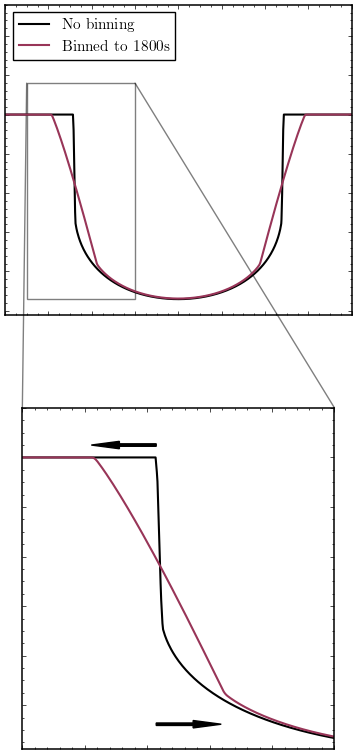

In [38]:

fig, ax = plt.subplots(figsize=(COLUMN, 0.9*COLUMN))

fig.set_facecolor("white")

ax.plot(t, lc, label="No binning", c="k", linestyle="solid", linewidth=1.5)
ax.plot(t, bin_lc, label="Binned to 1800s", c="#983558", linestyle="solid", linewidth=1.5)
ax.legend(frameon=True, fancybox=False, framealpha=1, edgecolor="k", fontsize=11, loc="upper left")

ax.set_ylim(min(lc)-0.01, 0.07)

ax.set_xlim(-0.08,0.08)

axins = ax.inset_axes([0.05, -1.4, 0.9, 1.1])

axins.plot(t, lc, label="Instanteneous sampling", c="k", linestyle="solid", linewidth=1.5)
axins.plot(t, bin_lc, label="Binned to 1800s", c="#983558", linestyle="solid", linewidth=1.5)

ax.set_xticklabels([])

ax.set_yticklabels([])

axins.set_xlim(-0.07,-0.02)
axins.set_ylim(min(lc), 0.02)

axins.set_xticklabels([])

axins.set_yticklabels([])

rectangle, lines = ax.indicate_inset_zoom(axins, edgecolor="black", zorder=1)

axins.arrow(t[np.nonzero(lc)[0][0]], 0.005, t[np.nonzero(bin_lc)[0][0]]-t[np.nonzero(lc)[0][0]], 0, length_includes_head=True, facecolor="k")
axins.arrow(t[np.nonzero(lc)[0][0]], min(lc) + 0.01, 1800/(3600*24*2), 0, length_includes_head=True, facecolor="k")

for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(1.1)
    ax.spines[axis].set_linewidth(1.1)

plt.tight_layout()

plt.savefig("cadence.pdf", bbox_inches='tight', pad_inches=0.2)


## Lightcurves become alike with longer cadences


### First generate the short and long cadence lightcurves for the two parameter sets

In [39]:

# Transit models for short and long cadence
tm_short = QuadraticModel()
tm_long = QuadraticModel()

t = np.linspace(-0.3, 0.3, 10000)

# Set corresponding 20s and 1800s cadences
tm_short.set_data(t, exptimes=20/(3600*24), nsamples=1000)
tm_long.set_data(t, exptimes=1800/(3600*24), nsamples=1000)

# Define parameters for the two sets 
k1= 0.0242 # Radius ratio
a1 = 10 # Semi-major axis in stellar radii units
p1 = 10 # Period in days
b1 = 0.9 # Impact parameter
i1 = np.arccos(b1/a1) # Inclination of the orbit

# Second set of parameters, same meaning as above
k2 = 0.02
a2 = a1 / np.sqrt(1 - b1 ** 2)
p2 = p1
b2 = 0
i2 = np.arccos(b2/a2)

# Limb-darkening parameters. Same for both sets.
ldc = [0.45, 0.2]

lc1_short = tm_short.evaluate(
    k = k1,
    ldc = ldc,
    t0 = 0,
    i = i1,
    a=a1,
    p = p1
)


# Generate long and short cadence lightcurves for both parameter sets
lc1_long = tm_long.evaluate(
    k = k1,
    ldc = ldc,
    t0 = 0,
    i = i1,
    a=a1,
    p = p1
)

lc2_short = tm_short.evaluate(
    k = k2,
    ldc = ldc,
    t0 = 0,
    i = i2,
    a=a2,
    p = p2
)

lc2_long = tm_long.evaluate(
    k = k2,
    ldc = ldc,
    t0 = 0,
    i = i2,
    a=a2,
    p = p2
)

# For plotting purposes, make 0 the baseline and use units of ppm
lc1_short = (lc1_short - 1) * 1e6
lc1_long = (lc1_long - 1) * 1e6
lc2_short = (lc2_short - 1) * 1e6
lc2_long = (lc2_long - 1) * 1e6


### Now plot the four lightcurves

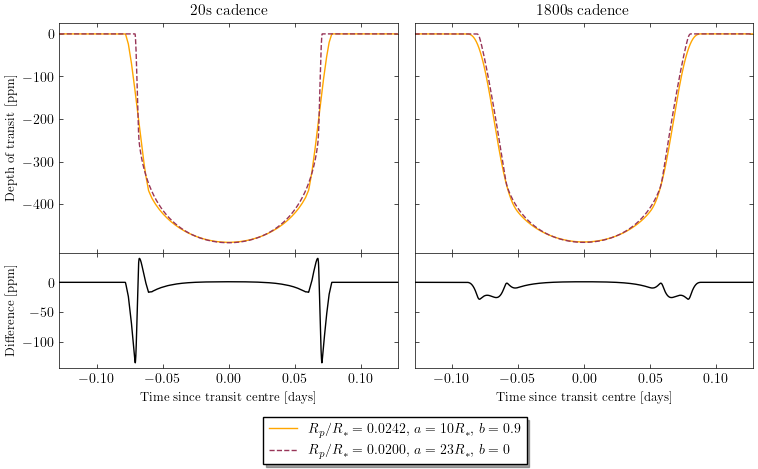

In [40]:

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(2*COLUMN, 1*COLUMN), gridspec_kw={'height_ratios': [2,1]}, sharex=True)

fig.subplots_adjust(hspace=0, wspace=0.05)

axes[0,0].set_xlim(t[np.nonzero(lc1_short)[0][0]] - 0.05, t[np.nonzero(lc1_short)[0][-1]] + 0.05)

axes[0,0].plot(t, lc1_short, color="#ffa600", linewidth=1)
axes[0,0].plot(t, lc2_short, color=PURPLE, linewidth=1, linestyle="--")

axes[0,1].plot(t, lc1_long, color="#ffa600", linewidth=1)
axes[0,1].plot(t, lc2_long, color=PURPLE, linewidth=1, linestyle="--")

ylim1 = axes[0,0].get_ylim()
ylim2 = axes[0,1].get_ylim()

ylim = [np.min([ylim1[0], ylim2[0]]), np.max([ylim1[1], ylim2[1]])]

axes[0,0].set_ylim(ylim)
axes[0,1].set_ylim(ylim)

axes[1,0].plot(t, lc1_short-lc2_short, c="k", linewidth=1)
axes[1,1].plot(t, lc1_long-lc2_long, c="k", linewidth=1)

ylim1 = axes[1,0].get_ylim()
ylim2 = axes[1,1].get_ylim()

ylim = [np.min([ylim1[0], ylim2[0]]), np.max([ylim1[1], ylim2[1]])]

axes[1,0].set_ylim(ylim)
axes[1,1].set_ylim(ylim)

for ax in np.hstack(axes):
    ax.tick_params(which="minor", bottom=False, top=False, left=False, right=False)

axes[0,1].set_yticks([])
axes[1,1].set_yticks([])

axes[0,0].set_title("20s cadence", fontsize=11)
axes[0,1].set_title("1800s cadence", fontsize=11)

handles = [Line2D([0],[0], color=ORANGE, linewidth=1), Line2D([0],[0], color=PURPLE, linewidth=1, linestyle="--")]

labels = [f"$R_p/R_* = 0.0242$, $a = {a1}R_*$, $b={b1}$", f"$R_p/R_* = 0.0200$, $a = {int(round(a2,0))}R_*$, $b={b2}$"]

axes[0,0].set_ylabel("Depth of transit [ppm]", fontsize=9)
axes[1,0].set_ylabel("Difference [ppm]", fontsize=9)

axes[0,0].set_yticks([0,-100,-200,-300,-400])
axes[1,0].set_yticks([0,-50,-100])
axes[0,1].set_yticks([0,-100,-200,-300,-400])
axes[1,1].set_yticks([0,-50,-100])

axes[0,1].set_yticklabels("")
axes[1,1].set_yticklabels("")

axes[1,0].set_xlabel("Time since transit centre [days]", fontsize=9)
axes[1,1].set_xlabel("Time since transit centre [days]", fontsize=9)


fig.legend(handles, labels, frameon=True, fancybox=False, framealpha=1, edgecolor="k", fontsize=10, loc="lower center", bbox_to_anchor=(0.5, -0.12), shadow=True)

plt.savefig("two_cadences.pdf", bbox_inches="tight")


# Numerical derivatives plot


### First generate derivatives making use of the exoplanet package and the exoInfoMatrix class

In [41]:

# The derivatives will be stored in a dictionary
derivs = dict()

# Derivatives are calculated for planetary values of HD 2685 obtained from our own fit
transit_duration = 0.1915 # days
period = 4.1269 # days
ror = 0.09467 # radius ratio
b = 0.2205 # impact parameter
u1 = 0.3241 # quadratic limb-darkening parameter 1
u2 = 0.0244 # quadratic limb-darkening parameter 2
m_star = 1.2889 # mass of star in solar mass
r_star = 1.5649 # radius of the star in solar radii

for exptime in [20, 600, 1800]:
    # Initialize the exoInfoMatrix object
    infmatrix = exoInfoMatrix(exptime, 1000)

    # Derivatives calculate for ~one transit
    t = np.linspace(-1.1*transit_duration, 1.1*transit_duration, 10000)

    # Set values
    infmatrix.set_data(
        time_array=t,
        period_val=period,
        t0_val=0,
        ror_val=ror,
        b_val=b,
        u1_val=u1,
        u2_val=u2,
        m_star_val=m_star,
        r_star_val=r_star
    )

    # Get derivative matrix and store it
    derivs[exptime] = infmatrix.eval_deriv_matrix()


### Now plot the derivatives

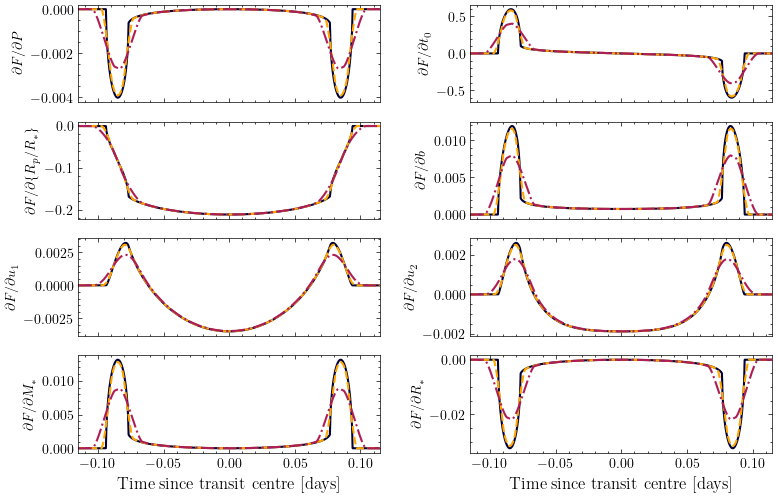

In [42]:

# First get the legend for the meaning of each row and column of the derivatives matrix
leg = infmatrix.legend

# Not interested in the time derivative
if "t" in leg:
    leg.pop('t')

# Define colors and linestyles for each cadence
colors = {
    20 : "#000035",
    1800 : "#ae1e55",
    600 : "#ffa600"
}

linestyles = {
    20 : "solid",
    600 : "dashed",
    1800 : "-."
}


# Set the layout of the figure, define titles
layout = [["period","t0"],["ror", "b"], ["u1","u2"], ["m_star","r_star"]]

titles = {
    "F" : "Lightcurve (relative flux) [ppm]",
    "period" : "$\partial F/\partial P$",
    "t0" : "$\partial F/\partial t_0$",
    "ror" : "$\partial F/\partial \{R_{p}/R_{*}\}$",
    "b" : "$\partial F/\partial b$",
    "u1" : "$\partial F/\partial u_1$",
    "u2" : "$\partial F/\partial u_2$",
    "m_star" : "$\partial F/\partial M_*$",
    "r_star" : "$\partial F/\partial R_*$"
}


fig, axes = plt.subplot_mosaic(mosaic=layout,figsize = (2*COLUMN, 1.3*COLUMN), sharex=True, gridspec_kw={"wspace": 0.3})
fig.set_facecolor("white")

for name in leg.keys():
    if name == "F": # Not interested in the flux itself
        continue

    axes[name].set_ylabel(titles[name])

    axes[name].tick_params(labelsize=10)
    axes[name].set_xlim(-0.6*transit_duration, 0.6*transit_duration)
    for exptime in [20, 600, 1800]:
        axes[name].plot(t, derivs[exptime][:,leg[name]+1], linewidth=1.5, c=colors[exptime], linestyle=linestyles[exptime], label=f"{exptime}s")

for name in layout[-1]:
    axes[name].set_xlabel("Time since transit centre [days]", fontsize=12)

plt.savefig("derivs.pdf", bbox_inches="tight")


# Precision improvement distributions


### First have to process the raw MCMC results

In [43]:

# Read raw csv file
results = pd.read_csv("../../mcmc_fit_results.csv")

# Now we want to compare all possible cadence1-cadence2 combinations possible for each system. That is, if a system has the following cadence-sector fitted lightcurves
# 20s-20, 20s-21, 1800s-21, 1800s-23
# We make a comparison between all of them, leading to the following comparisons
# 20s-20 vs 1800s-21, 20s-20 vs 1800s-23, 20s-11 vs 1800s-21, 20s-1800s-23
# So we compare all cadences to eachother (except some cadence to the same cadence)

# Pandas dataframe (df) to hold pairwise comparisons
pairsdf = pd.DataFrame(
    columns=["hostname", "expt1", "expt2", "sect1", "sect2", "samesect", "ror_sd_ratio"]
)

# Iterate through results
for i, row in results.iterrows():
    # Extract the hostname, the exposure time of the current row and its sector
    hostname = row["hostname"]
    expt1 = row["exptime"]
    sect1 = row["sectors"]

    # Extract from the full table of results, only those from the same system and with a cadence larger than our current row
    subdf = results[(results["hostname"] == hostname) & (results["exptime"] > expt1)]

    # For each of the results in the subselection, we make comparisons
    for j, srow in subdf.iterrows():
        expt2 = srow["exptime"]
        sect2 = srow["sectors"]

        # Divide shorter cadence radius ratio standard deviation to that of the longer cadence
        ror_sd_ratio = row["ror_sd"] / srow["ror_sd"]

        # If the sectors are the same, add a True flag
        samesect = False
        if sect1 == sect2:
            samesect = True

        # And add the row to the pairs dataframe
        pairsdf.loc[len(pairsdf)] = [hostname, expt1, expt2, sect1, sect2, samesect, ror_sd_ratio]


### Now plot the distributions

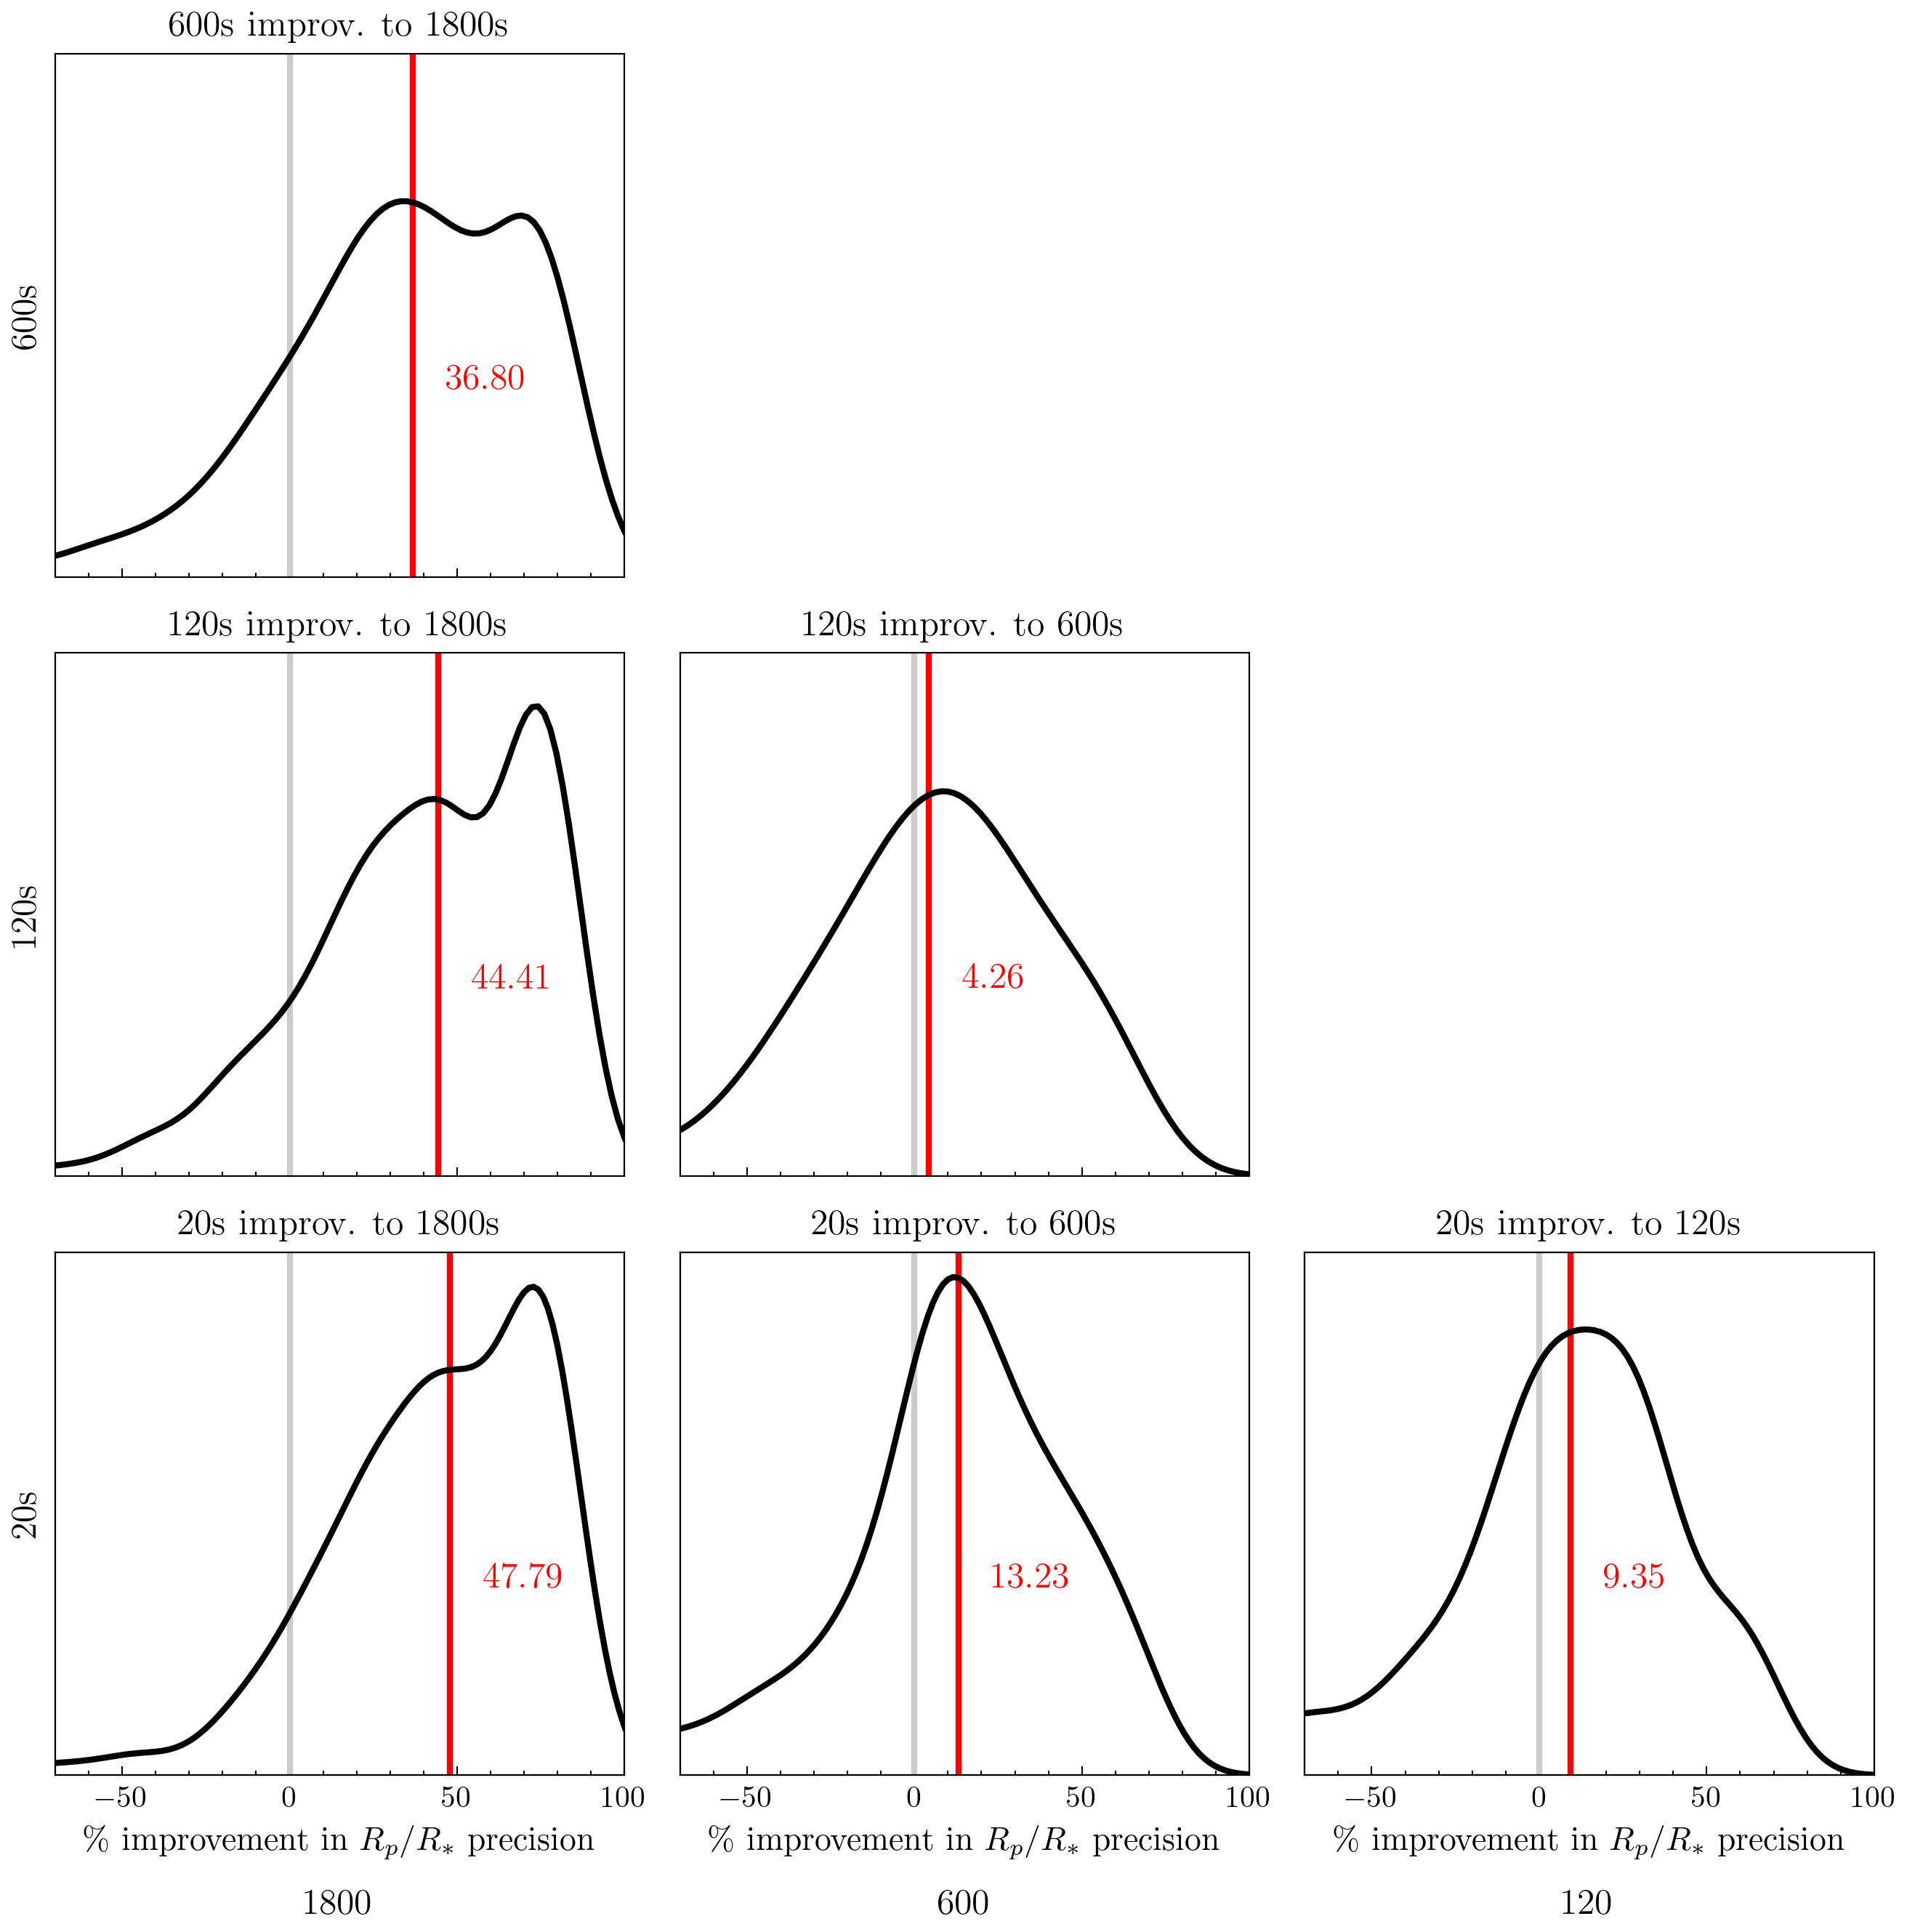

In [44]:

fig, ax = plt.subplots(3, 3, dpi=300, figsize=(2*COLUMN, 2*COLUMN), sharex=True, sharey=True)

exptimes = [20, 120, 600, 1800]

for i, expt1 in enumerate(reversed(exptimes[:-1])):
    for j, expt2 in enumerate(reversed(exptimes[1:])):
        if expt2 <= expt1:
            ax[i, j].remove()
        else:
            if i == 2:
                ax[i, j].set_xlabel(f"\% improvement in $R_p/R_*$ precision", fontsize=11)
                ax2 = ax[i, j].twiny()
                ax2.set_xticks([])
                title = ax2.set_title(f"{expt2}", x=0.5, y=-0.3, fontsize=12)

            if j == 0:
                ax[i, j].set_ylabel(f"{expt1}s", fontsize=12)
                ax[i, j].set_yticks([])

            ax[i, j].set_xlim(-70, 100)
            ax[i, j].axvline(0, c="0.8", linewidth=2)

            ax2 = ax[i, j].twiny()
            ax2.set_xticks([])

            # Get only pairs that compare the current short and long cadences that are being ploted
            data = pairsdf[(pairsdf["expt1"] == expt1) & (pairsdf["expt2"] == expt2)][
                "ror_sd_ratio"
            ].to_numpy()

            # We plot % improvement (1 - sigma_short/sigma_long) * 100
            data = (1 - data) * 100

            # Remove any outliers (values above 500)
            data = [value for value in data if (value > -500) and (value < 500)]

            # Plot medians of the data
            ax[i, j].axvline(np.median(data), c="r", linewidth=2)
            ax[i, j].text(np.median(data)+10, 0.005, f'{np.median(data):.2f}', c="r", fontsize=12)

            ax[i, j].set_title(f"{expt1}s improv. to {expt2}s")

            # Plot the actual distribution using kdeplot
            sns.kdeplot(data, ax=ax[i, j], c="k", linewidth=2)

plt.tight_layout()

plt.savefig("ror.pdf", bbox_inches='tight')


# Errors of the Information Analysis

In [45]:

# Read the data with the information analysis predictions

results = pd.read_csv("../../information_analysis_results.csv")

# calculate percentage values of the standard deviation
results["ror_sd_percent"] = results["ror_sd"] / results["ror_median"]
results["ror_fisher_sd_percent"] = results["ror_fisher_sd"] / results["ror_median"]

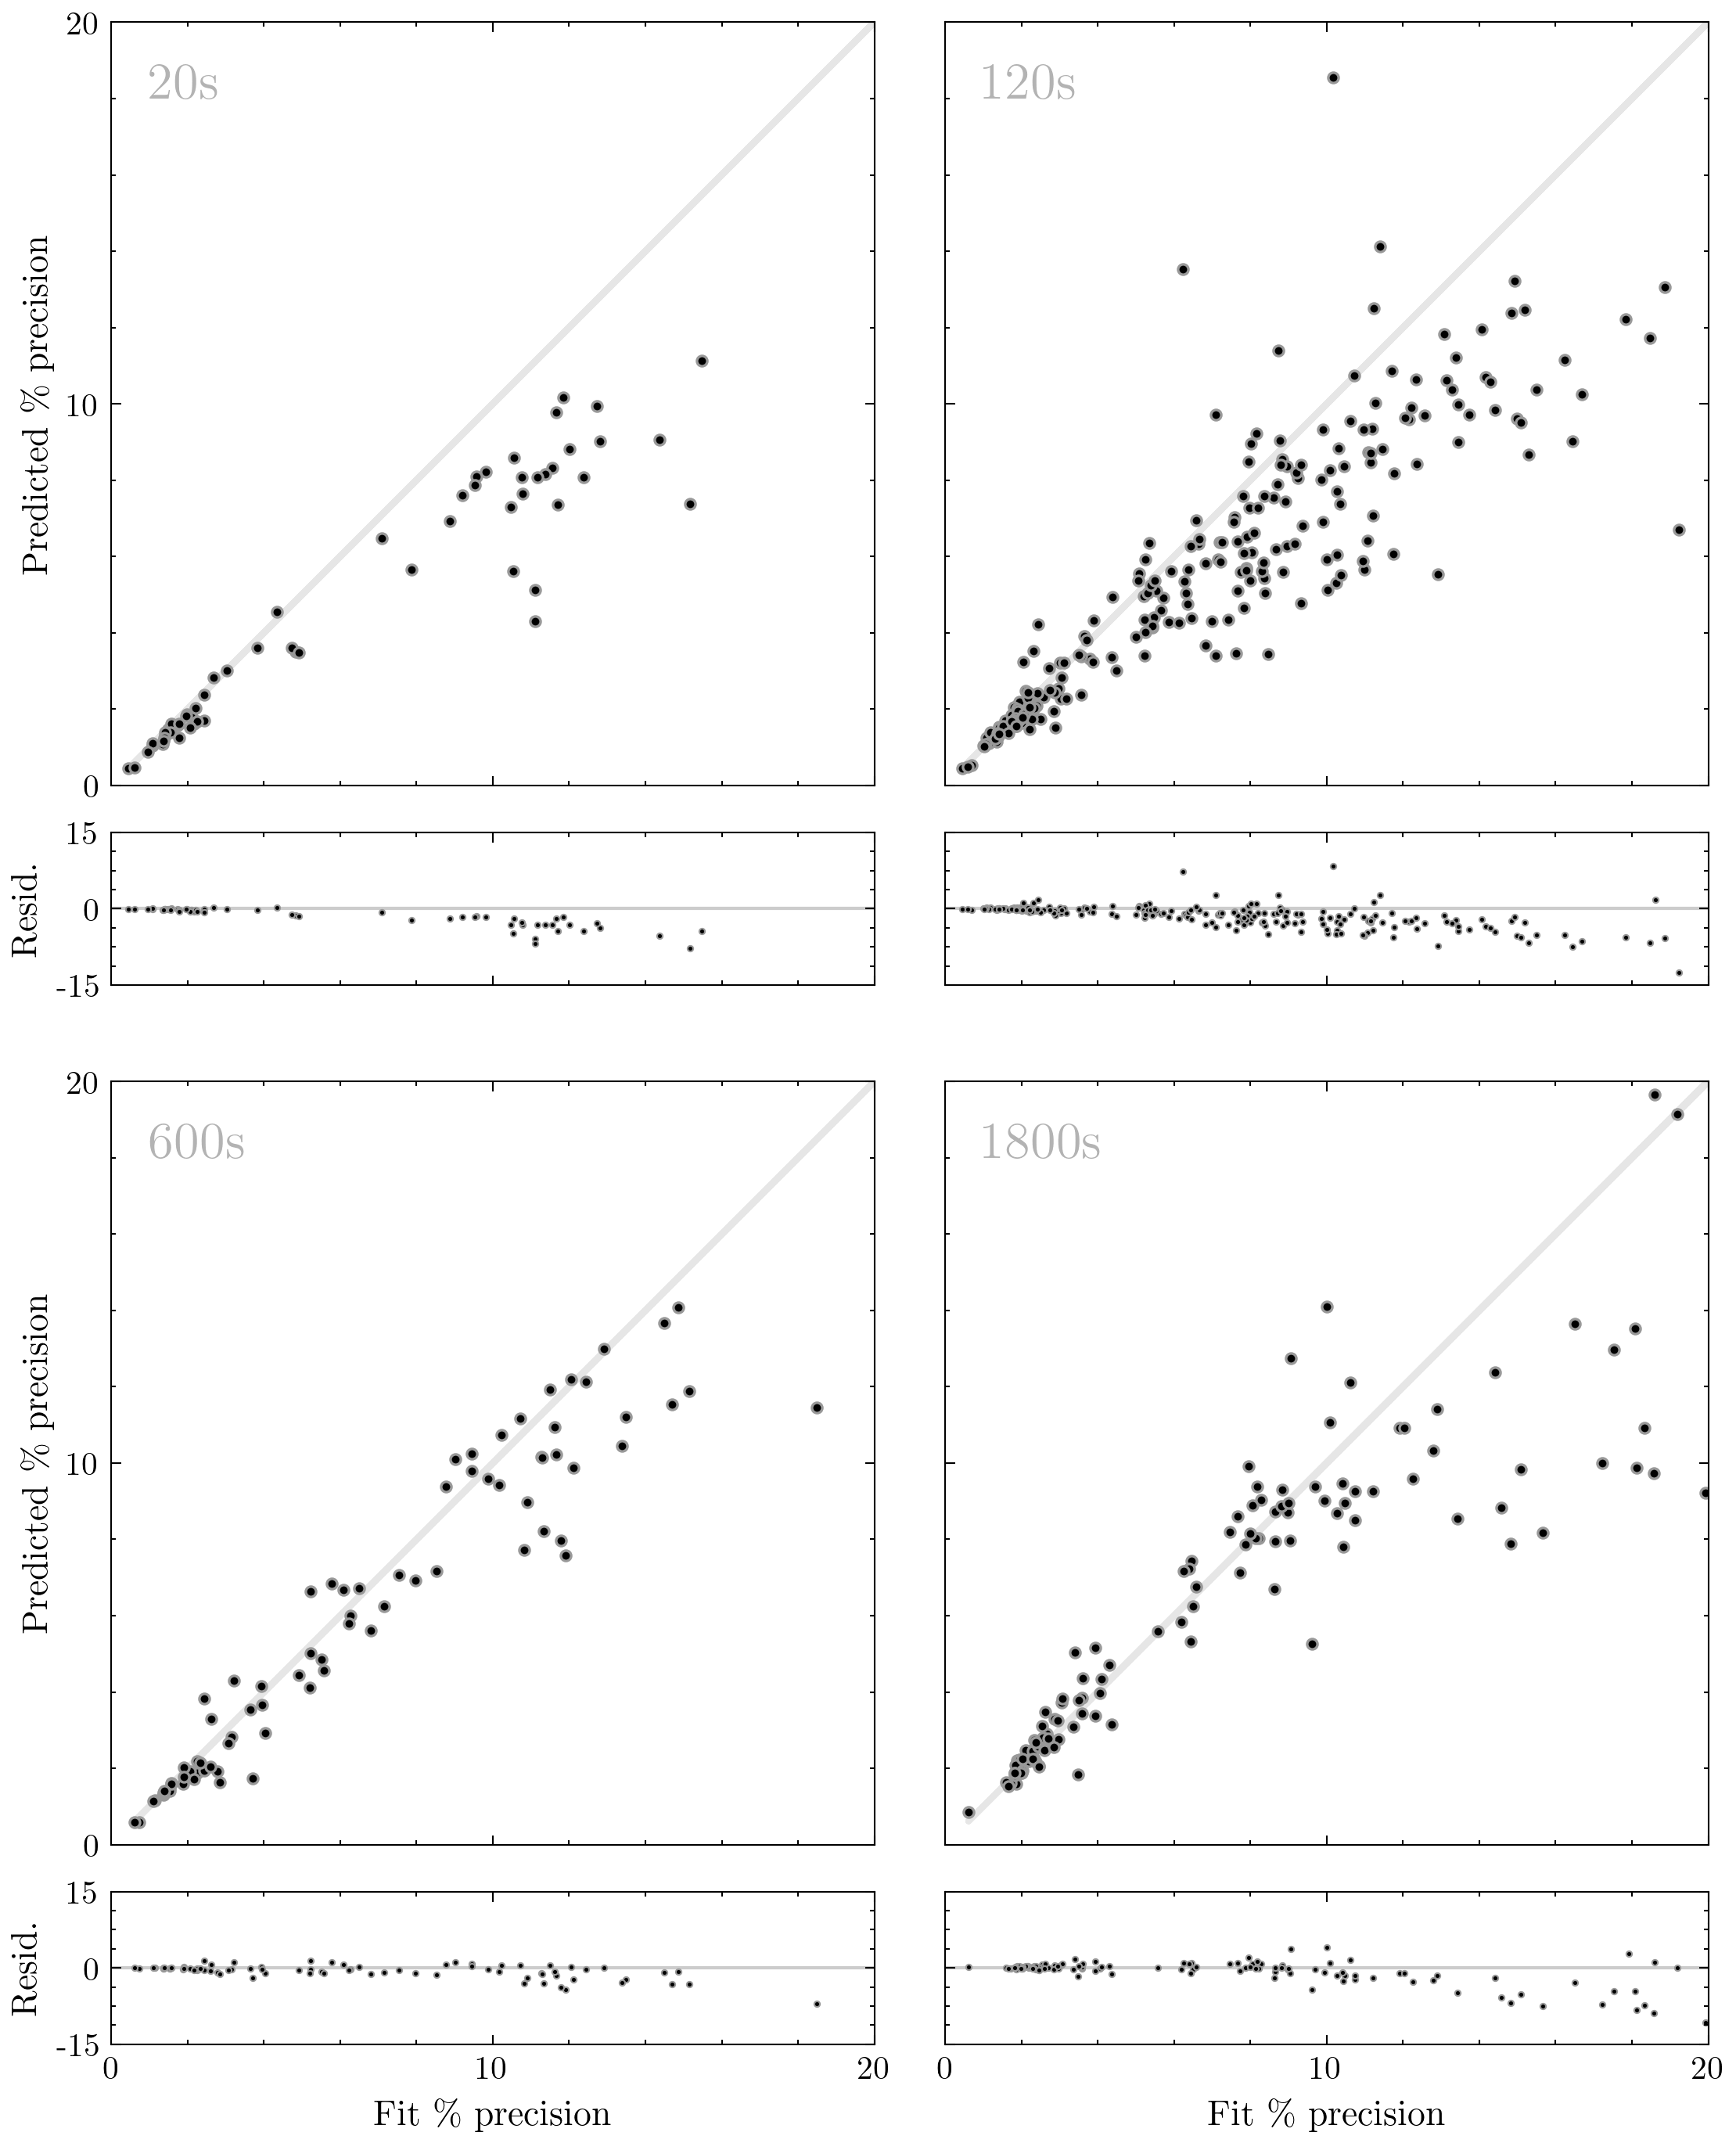

In [46]:

# And plot them

# Ticks for main plots, sticks for residuals plots
ticks = np.arange(0, 30, 10)
sticks = np.linspace(-15, 15, 3)
sticks = [int(tick) for tick in sticks]
tickslabels = [str(tick) for tick in ticks]
stickslabels = [str(tick) for tick in sticks]

# Function to plot both main plot and residuals plot
def createplot(ax, x, y, cadence, size="20%", pad=0, xlabel=False, ylabel=False):
    global ticks
    global sticks
    global tickslabels
    global stickslabels

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size=size, pad=pad)
    ax.figure.add_axes(ax2)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks(ticks)
    ax.set_xticklabels([])

    if not xlabel:
        ax2.set_xticks(ticks)
        ax2.set_xticklabels([])
    else:
        ax2.set_xticks(ticks)
        ax2.set_xticklabels(tickslabels)
        ax2.set_xlabel("Fit \% precision", fontsize=11)
    if not ylabel:
        ax.set_yticks(ticks)
        ax.set_yticklabels([])
        ax2.set_yticks(sticks)
        ax2.set_yticklabels([])
    else:
        ax.set_yticks(ticks)
        ax.set_yticklabels(tickslabels)
        ax2.set_yticks(sticks)
        ax2.set_yticklabels(stickslabels)

        ax.set_ylabel(f"Predicted \% precision", fontsize=11)
        ax2.set_ylabel(f"Resid.", fontsize=11)


    ax2.set_xlim(0, 20)
    ax2.set_ylim(min(sticks), max(sticks))

    ax.scatter(x, y, s=10, c="k", edgecolor="0.6", linewidth=0.8)
    ax.plot(x, x, linewidth=2, c="0.9", zorder=0)
    ax.text(1, 18, f"{cadence}s", c="0.7", fontsize=16)

    ax2.axhline(0, c="0.8", zorder=0)
    ax2.scatter(x, (y-x), s=3, c="k", edgecolor="0.6", linewidth=0.5)

# Create figure
fig, ax = plt.subplots(2, 2, dpi=300, figsize=(2*COLUMN,2.5*COLUMN), sharex=True, sharey=False, gridspec_kw={ "wspace": 0.05 , "hspace": 0.1})

exptimes = [20, 120, 600, 1800]

for i, expt in enumerate(exptimes):

    j = (int(i / 2) % 2)

    i = i % 2

    ax[j, i].set_xlim(0, 20)
    ax[j, i].set_ylim(0, 20)

    # x corresponds to the mcmc values
    x = results[results["exptime"] == expt][
    "ror_sd_percent"
    ].to_numpy()

    y = results[results["exptime"] == expt][
    "ror_fisher_sd_percent"
    ].to_numpy()

    s = results[results["exptime"] == expt][
    "ror_median"
    ].to_numpy()

    # Plot percent
    x = x * 100
    y = y * 100

    xlabel = False
    ylabel = False

    if j == 1:
        xlabel = True
    if i == 0:
        ylabel = True

    createplot(ax[j,i], x, y, expt, pad=0.2, xlabel=xlabel, ylabel=ylabel)

plt.savefig("information_results.pdf", bbox_inches='tight')


# Multisector plots

In [4]:

# Load single and multi sector results. Multisector results include the information analysis predictions

single = pd.read_csv("../../mcmc_fit_results.csv")
multi = pd.read_csv("../../multisector_results.csv")

0.004766292132829611 0.0034981107338405352
0.004813142844449631 0.0042673614253960854
0.01631024790862307 0.011864234278992246
0.002839799445765265 0.0025600977233138176
0.0034192519770308845 0.002960021431115015
0.005452056558780792 0.005913643750235117
0.0012558241777308834 0.0011531989961028834
0.001364389961380969 0.0013125966602108847
0.0016458205846947751 0.001566494159773275
0.003818186941370388 0.0031447891199352083
0.003835351735550831 0.0025491681640058693
0.0047927641355966 0.0032322921024297
Bbox(x0=0.125, y0=0.1100000000000001, x1=0.9000000000000001, y1=0.19774193548387106)


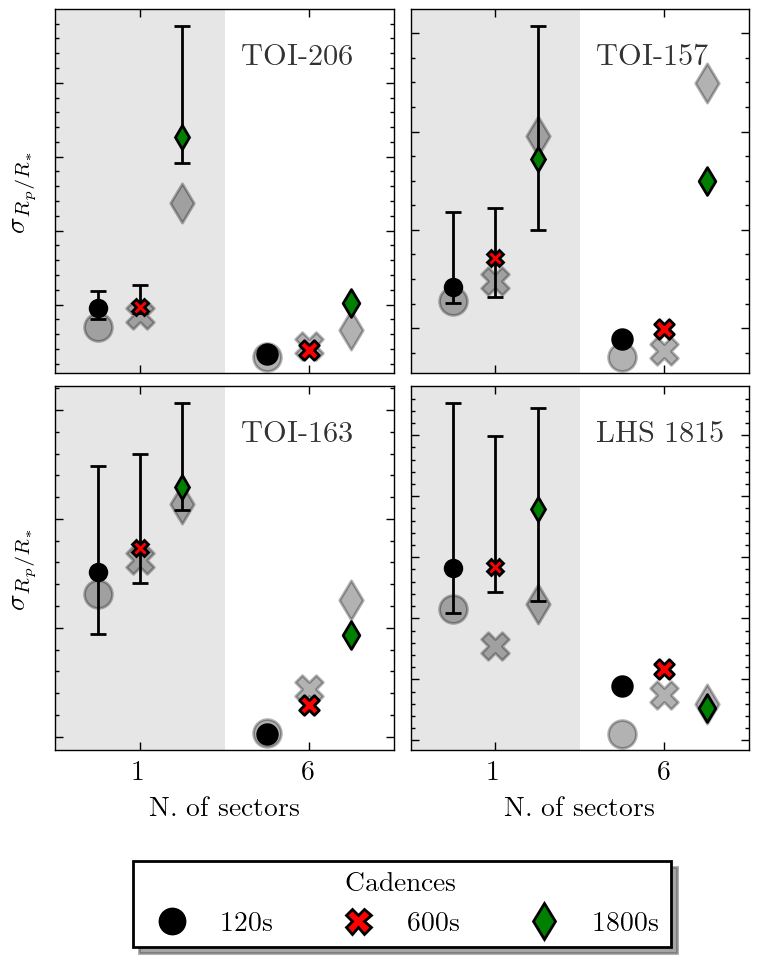

In [14]:

# Plot the single and multi sector precisions

# These are the systems to be plotted
plothosts = ["TOI-206", "TOI-157", "TOI-163", "LHS 1815"]

# Markers, colors and offsets for the points
markers = {
    120: {"marker": "o", "color": "k", "offset": -0.25},
    600: {"marker": "X", "color": "r", "offset": 0},
    1800: {"marker": "d", "color": "g", "offset": 0.25},
}

# Layout for the plot
mosaic = [["A", "B"], ["C", "D"], ["F", "F"]]

fig, axes = plt.subplot_mosaic(mosaic, figsize=(COLUMN, 1.2 * COLUMN), dpi=200, sharex=False, sharey=False, height_ratios=[5,5,1], gridspec_kw={"wspace": 0.05, "hspace": 0.05})

for host, ax in zip(plothosts, np.array(list(axes.values())).flatten()):
    ax.text(0.55, 0.85, f"{host}", fontsize=11, c="0.2", transform=ax.transAxes)

    ax.set_xlim(0.5, 2.5)
    ax.axvspan(0, 1.5, facecolor="0.9")

    ax.set_xticks([1, 2], minor=False)
    ax.tick_params(which="minor", top=False, bottom=False)
    ax.set_xticklabels([])

    for expt in [120, 600, 1800]:
        singleval = single[(single["hostname"] == host) & (single["exptime"] == expt)][
            "ror_sd"
        ].to_numpy()
        multival = multi[(multi["hostname"] == host) & (multi["exptime"] == expt)][
            "ror_sd"
        ].to_numpy()
        infoval = multi[(multi["hostname"] == host) & (multi["exptime"] == expt)][
            "ror_fisher_sd"
        ].to_numpy()

        if len(singleval) == 0:
            continue

        singlevalmean = np.mean(singleval)
        singlevalsd = np.std(singleval)
        multivalmean = np.mean(multival)
        multivalsd = np.std(multival)

        ax.errorbar(
            1 + markers[expt]["offset"],
            np.mean(singleval),
            yerr=np.array([
                [np.abs(np.median(singleval) - np.percentile(singleval,16))],
                [np.abs(np.percentile(singleval, 84) - np.median(singleval))]
            ]),
            marker=markers[expt]["marker"],
            markerfacecolor=markers[expt]["color"],
            markeredgecolor="k",
            markersize= 6,
            elinewidth=1,
            ecolor = "k",
            capsize=3
        )

        ax.scatter(
            2 + markers[expt]["offset"],
            multivalmean,
            marker=markers[expt]["marker"],
            facecolor=markers[expt]["color"],
            edgecolor="k",
            s=50,
        )

        ax.scatter(
            2 + markers[expt]["offset"],
            np.mean(infoval),
            marker=markers[expt]["marker"],
            c="k",
            edgecolor="k",
            s=100,
            alpha=0.3,
            zorder=0
        )

        ax.set_yticklabels([])

axes["F"].axis(False)

handles = [
    Line2D([0], [0], marker=markers[expt]["marker"], color=markers[expt]["color"], label=f"{expt}s", linewidth=0, markeredgecolor="k", markersize=9) for expt in [120,600,1800]
]

axes["F"].legend(handles=handles,fontsize=10, title="Cadences", frameon=True, fancybox=False, shadow=True, loc="upper center", ncol=3, edgecolor="k", bbox_to_anchor=(0.5, -0.12))

for let in ["A", "C"]:
    axes[let].set_ylabel("$\sigma_{R_p/R_*}$", fontsize=10)
    axes[let].tick_params(labelsize=10)

for let in ["C", "D"]:
    axes[let].set_xlabel("N. of sectors", fontsize=10)
    axes[let].set_xticklabels(["1", "6"], fontsize=10)

ax = axes["F"]

plt.tight_layout()

box = ax.get_position()

box.y1 = box.y1 + 0.02
print(box)

ax.set_position(box)

plt.savefig('multisector.pdf', bbox_inches='tight')


# Distribution of precision improvements for TOIs

In [58]:

# Read data
df = pd.read_csv("../../tois_with_predictions.csv")

# Ratio of precisions 20s to 1800s cadence

df["20sratio"] = df["ror_20_sd"] / df["ror_1800_sd"]
df["120sratio"] = df["ror_120_sd"] / df["ror_1800_sd"]
df["600sratio"] = df["ror_600_sd"] / df["ror_1800_sd"]

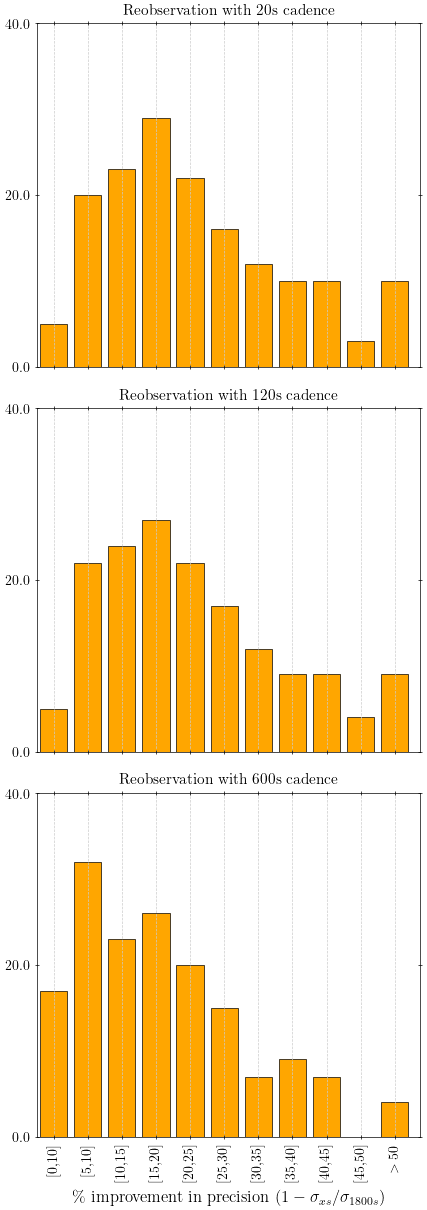

In [62]:


# Create bins, labels for the bins
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 10000]

positions = [i for i in range(len(bins)-1)]

labels = []

for i, bin in enumerate(bins):
    if i == 0 :
        labels.append(f"[0,10]")
    elif i == len(bins)-1:
        continue
    elif i == len(bins)-2:
        labels.append(f"$>{bins[-2]}$")
    else:
        labels.append(f"[{bin},{bins[i+1]}]")

fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(COLUMN, 2.75*COLUMN), sharex=True)

for i, exptime in enumerate([20,120, 600]):

    ax = axes[i]

    improvements = (1 - df[f"{exptime}sratio"]) * 100

    imrovements = improvements.dropna()

    hist, edges = np.histogram(improvements, bins=bins)

    top = max(hist)

    yticks = np.array([i if i % 20 == 0 else np.nan for i in range(0, top+20)])

    yticks = yticks[~np.isnan(yticks)]

    ylabels = [str(yticks[i]) if i % 1 == 0 else "" for i in range(len(yticks))]


    ax.bar(positions, hist, width=0.8, color=ORANGE, edgecolor="k", linewidth=0.5, label="MCMC")

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)

    ax.set_xticks(positions, minor=False)
    ax.set_xticklabels(labels, rotation=90, ha="center", verticalalignment="top", fontsize=10)

    ax.grid(axis="x", color="0.8", linestyle="dashed")

    ax.set_xlim(positions[0]-0.5, positions[-1]+0.75)

    middle = positions[int(len(positions)/2)]

#    ax.axvline(1, c = "darkred", linewidth=1)

    ax.set_title(f"Reobservation with {exptime}s cadence", fontsize=11)
#    ax.set_ylabel("N. of systems")


axes[-1].set_xlabel("\% improvement in precision ($1 - \sigma_{xs}/\sigma_{1800s}$)", fontsize=12)


for ax in axes:
    ax.tick_params(which="major", direction='inout')
    ax.tick_params(which='minor', bottom=False, left=False, right=False, top=False)

plt.tight_layout()


# Compare predictions with non-limb-darkened predictions

0.06766917293233082
-1.3899718927526696
0.5789473684210527
-11.619848902702461


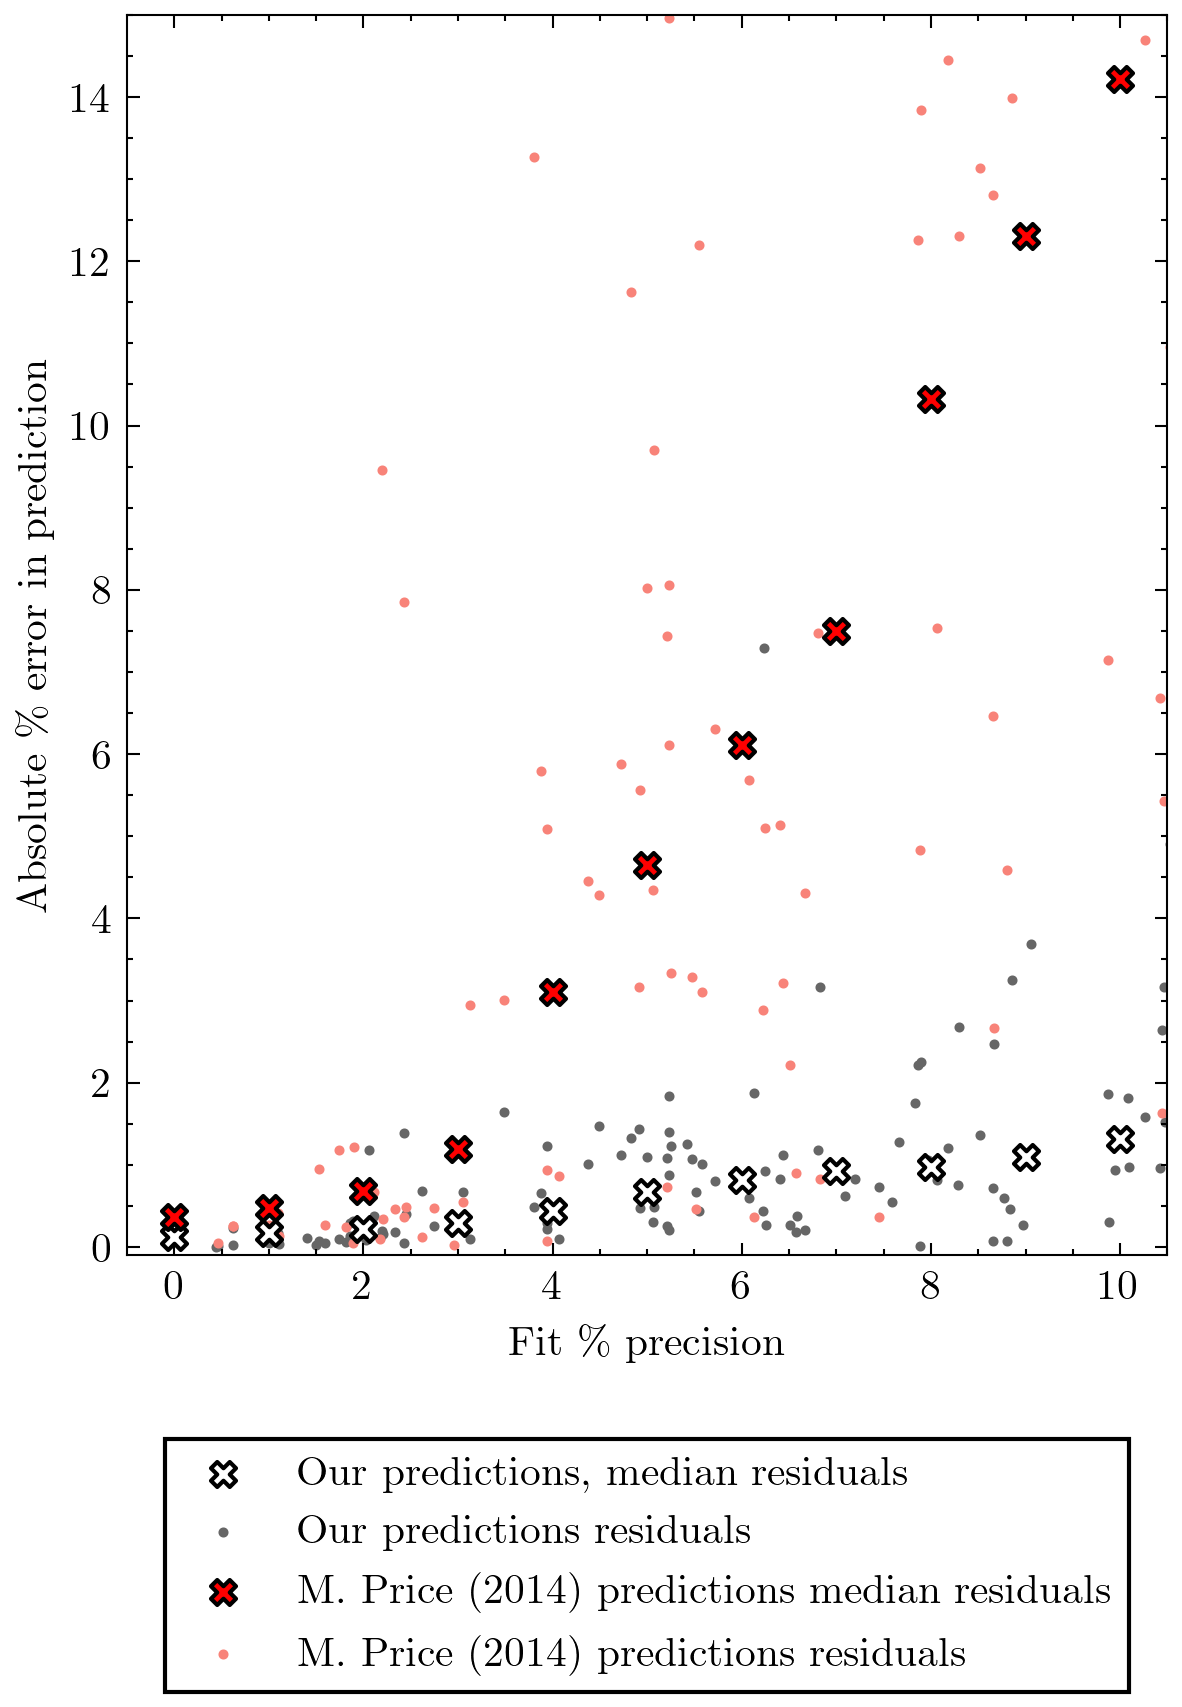

In [23]:

# Read the data with the information analysis predictions and for non-limb-darkened predictions

results = pd.read_csv("../../information_analysis_results.csv")
results = results.sort_values(by=["hostname", "exptime", "ror_sd"]).drop_duplicates(subset=["hostname", "exptime"], keep="first")

priceresults = pd.read_csv("../nolimbdarkeningpredictions/results_with_price_predictions.csv")
priceresults = priceresults.sort_values(by=["hostname", "exptime", "ror_sd"]).drop_duplicates(subset=["hostname", "exptime"], keep="first")

# calculate percentage values of the standard deviation
results["ror_sd_percent"] = results["ror_sd"] / results["ror_median"]
results["ror_fisher_sd_percent"] = results["ror_fisher_sd"] / results["ror_median"]

priceresults["ror_sd_percent"] = priceresults["ror_sd"] / priceresults["ror_median"]
priceresults["ror_price_sd_percent"] = priceresults["ror_price_sd"] / priceresults["ror_median"]

# Read our predictions and fit precisions
predicted = results["ror_fisher_sd_percent"] * 100
fits = results["ror_sd_percent"] * 100 
pricepredicted = priceresults["ror_price_sd_percent"] * 100
pricefits = priceresults["ror_sd_percent"] * 100

# And the absolute errors
errors = np.abs(predicted - fits)
signederrors = fits - predicted 
priceerrors = np.abs(pricepredicted - pricefits)
signedpriceerrors = pricefits - pricepredicted 

# Set x data points up to the 90 percentile of the fits errors (to avoid edge effects)
maxfiterrs = np.arange(0, np.percentile(fits, 80), 1)

# Now we calculate the median values of the absolute errors in the predictions for each of the x values of maximum fit error

medianerrors = []
pricemedianerrors = []

for maxfiterr in maxfiterrs:
    # Mask to select only values for which the fit error is smaller than maxfiterr
    mask = [maxfiterr - 3 <= value <= maxfiterr + 3 for value in fits]
#    mask = [value <= maxfiterr for value in fits]

    medianerror = np.nanmedian(errors[mask])
    pricemedianerror = np.nanmedian(priceerrors[mask])

    medianerrors.append(medianerror)
    pricemedianerrors.append(pricemedianerror)

# Now plot

fig, ax = plt.subplots(figsize=(COLUMN, 1.2*COLUMN), dpi=300)

ax.scatter(maxfiterrs, medianerrors, c="w", edgecolor="k", linewidth=1, marker='X', label='Our predictions, median residuals', zorder=100)
ax.scatter(fits, errors, c="0.4", marker='o', label='Our predictions residuals', s=2)
ax.scatter(maxfiterrs, pricemedianerrors, c="r", marker='X', label='M. Price (2014) predictions median residuals', edgecolor="k", linewidth=1, zorder=100)

ax.scatter(pricefits, priceerrors, c="#F88379", marker='o', label='M. Price (2014) predictions residuals', s=2)

#ax.scatter(maxfiterrs, np.array(pricemeanerrors) / np.array(meanerrors), c="g", marker='X', label='Ratio M. Price (2014) err. / Our predictions err.', edgecolor="k", linewidth=1, zorder=100)

ax.set_xlim(-0.5, np.percentile(fits, 95) + 0.5)
ax.set_ylim(-0.1,15)
ax.set_xlim(-0.5,10.5)

ax.set_xlabel("Fit \% precision", fontsize=10)
ax.set_ylabel("Absolute \% error in prediction", fontsize=10)

ax.legend(frameon=True, fancybox=False, framealpha=1, edgecolor="k", fontsize=10, loc="center", bbox_to_anchor=(0.5,-0.25))

plt.savefig("compare_price.pdf", bbox_inches="tight")

print(len(signederrors[signederrors < -1]) / len(signederrors))
print(np.median(signederrors[signederrors < -1]))
print(len(signedpriceerrors[signedpriceerrors < -1]) / len(signedpriceerrors))
print(np.median(signedpriceerrors[signedpriceerrors < -1]))